<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [1]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz


# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import sklearn.cluster as cluster

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl
from scipy import sparse
from numpy import asarray
from numpy import savetxt

# Fix imbalance
from imblearn.under_sampling import InstanceHardnessThreshold

# Model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

C:\Users\Miguel\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## 3. Model building and evaluation: Machine Learning

### Using types

#### Truncated SVD 

##### original sample

In [2]:
result_svd_vec_types  = pd.read_csv("data/output_csv/result_svd_vec_types.csv")
result_svd_vec_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [3]:
result_svd_vec_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,90,91,92,93,94,95,96,97,98,99
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,0.343928,0.360159,0.358680,0.351273,0.402498,0.357498,0.376758,0.379303,0.367843,0.375516
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0.351512,0.375683,0.352008,0.356475,0.332874,0.386907,0.356917,0.354533,0.377601,0.337164
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0.332374,0.354798,0.362468,0.352909,0.367732,0.342600,0.336408,0.357758,0.344202,0.391195
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0.370720,0.335693,0.393478,0.349815,0.373543,0.380157,0.381040,0.335247,0.360196,0.377249
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0.337362,0.363822,0.328088,0.336720,0.373329,0.376424,0.356934,0.367272,0.333998,0.381967


In [4]:
result_svd_vec_types.shape

(8675, 119)

In [84]:
X = result_svd_vec_types.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = result_svd_vec_types["type"].values

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 102) (6940,) (1735, 102) (1735,)


In [7]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [8]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [9]:
raise SystemExit("Here it comes a very consuming memory process that takes about 45 minutes")

SystemExit: Here it comes a very consuming memory process that takes about 45 minutes

In [10]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_svd.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.558646,0.589528,0.555476,0.558908,0.967280
0,logit,0.210663,0.091524,0.213112,0.108632,0.937515
0,knn,0.147118,0.146136,0.148847,0.137005,0.938348
0,decisiontree,0.423631,0.422836,0.417003,0.417839,0.958674
0,randomforest,0.618012,0.630657,0.616571,0.590044,0.971653
0,xgboost,0.633285,0.625011,0.627954,0.622888,0.973981
0,MLPC,0.572046,0.536335,0.567723,0.506253,0.968359


###### Feature importance

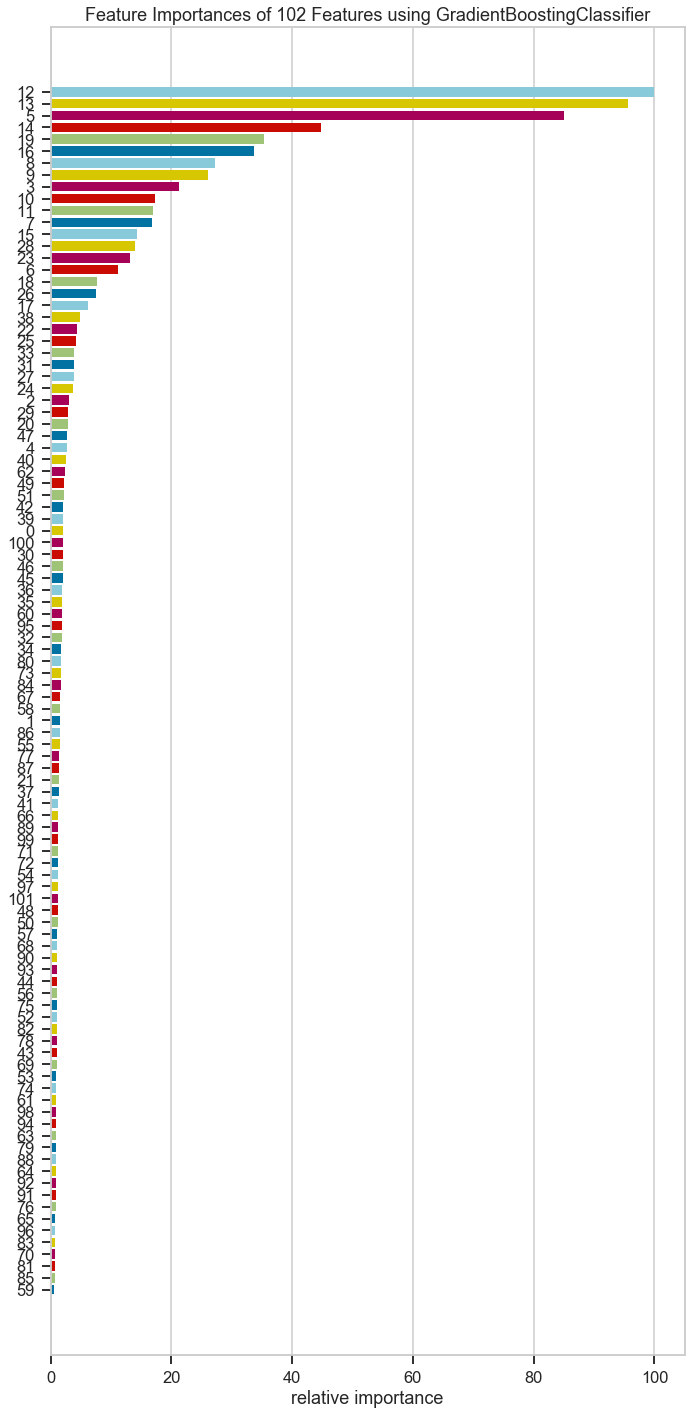

In [86]:
xgboost = GradientBoostingClassifier().fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
viz = FeatureImportances(xgboost)
viz.fit(X, y)
viz.show(outpath="images/output_images/feature_importance_types.png")
sns.set_context("talk")
plt.show()

##### resampled

In [12]:
result_svd_vec_types  = pd.read_csv("data/output_csv/result_svd_vec_types.csv")
result_svd_vec_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [13]:
result_svd_vec_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,90,91,92,93,94,95,96,97,98,99
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,0.343928,0.360159,0.358680,0.351273,0.402498,0.357498,0.376758,0.379303,0.367843,0.375516
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0.351512,0.375683,0.352008,0.356475,0.332874,0.386907,0.356917,0.354533,0.377601,0.337164
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0.332374,0.354798,0.362468,0.352909,0.367732,0.342600,0.336408,0.357758,0.344202,0.391195
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0.370720,0.335693,0.393478,0.349815,0.373543,0.380157,0.381040,0.335247,0.360196,0.377249
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0.337362,0.363822,0.328088,0.336720,0.373329,0.376424,0.356934,0.367272,0.333998,0.381967


In [14]:
result_svd_vec_types.shape

(8675, 119)

In [15]:
def sampling_k_elements(group, k=39):
    if len(group) < k:
        return group
    return group.sample(k)

balanced_svd = result_svd_vec_types.groupby("type").apply(sampling_k_elements).reset_index(drop=True)

In [16]:
X = balanced_svd.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = balanced_svd["type"].values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(499, 102) (499,) (125, 102) (125,)


In [18]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity': [specificity]
                            })   
    return df_model

In [19]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [20]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_svd_resampled.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.420828,0.478576,0.420869,0.424358,0.962788
0,logit,0.140424,0.219306,0.172404,0.159622,0.941482
0,knn,0.064141,0.123761,0.076182,0.058451,0.939582
0,decisiontree,0.272586,0.261215,0.218303,0.218309,0.946661
0,randomforest,0.454869,0.508494,0.476707,0.449604,0.965543
0,xgboost,0.412848,0.404027,0.364626,0.391002,0.960844
0,MLPC,0.098222,0.075802,0.084141,0.056600,0.939084


#### UMAP

##### original sample

In [21]:
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")
result_umap_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [22]:
result_umap_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [23]:
result_umap_types.shape

(8675, 21)

In [24]:
X = result_umap_types.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = result_umap_types["type"].values

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 4) (6940,) (1735, 4) (1735,)


In [26]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity': [specificity]
                            })   
    return df_model

In [27]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [28]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_umap.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.247550,0.163636,0.246254,0.170810,0.942453
0,logit,0.240202,0.139118,0.244524,0.162082,0.941679
0,knn,0.165706,0.158060,0.163689,0.158168,0.939635
0,decisiontree,0.162536,0.160048,0.161239,0.160094,0.940114
0,randomforest,0.219164,0.177404,0.214409,0.194880,0.942896
0,xgboost,0.229107,0.191042,0.230692,0.200049,0.942650
0,MLPC,0.233718,0.179412,0.227810,0.153369,0.942347


##### resampled

In [29]:
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")
result_umap_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [30]:
result_umap_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [31]:
result_umap_types.shape

(8675, 21)

In [32]:
def sampling_k_elements(group, k=39):
    if len(group) < k:
        return group
    return group.sample(k)

balanced_umap = result_umap_types.groupby("type").apply(sampling_k_elements).reset_index(drop=True)

In [33]:
X = balanced_umap.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = balanced_umap["type"].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(499, 4) (499,) (125, 4) (125,)


In [35]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity': [specificity]
                            })   
    return df_model

In [36]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [37]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_umap_resampled.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.116182,0.077189,0.118202,0.090590,0.941958
0,logit,0.114283,0.088460,0.118162,0.086173,0.939492
0,knn,0.046121,0.070279,0.062141,0.055316,0.937192
0,decisiontree,0.094182,0.064393,0.080242,0.092873,0.937284
0,randomforest,0.104202,0.120941,0.092121,0.109172,0.938772
0,xgboost,0.112222,0.086342,0.104121,0.100297,0.937069
0,MLPC,0.088202,0.058612,0.078202,0.071256,0.942436


#### UMAP on TSVD

##### original sample

In [38]:
result_umap_svd_types  = pd.read_csv("data/output_csv/result_umap_svd_types.csv")
result_umap_svd_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [39]:
result_umap_svd_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,12.761392,3.539108
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,11.170195,0.726455


In [40]:
result_umap_svd_types.shape

(8675, 21)

In [41]:
X = result_umap_svd_types.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = result_umap_svd_types["type"].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 4) (6940,) (1735, 4) (1735,)


In [43]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity': [specificity]
                            })   
    return df_model

In [44]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [45]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_umap_svd.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.339049,0.270229,0.340778,0.286999,0.950001
0,logit,0.293084,0.224370,0.299280,0.229524,0.946228
0,knn,0.240634,0.230644,0.240778,0.232345,0.945984
0,decisiontree,0.314553,0.315976,0.318444,0.319963,0.951963
0,randomforest,0.422334,0.427817,0.425793,0.405750,0.957707
0,xgboost,0.413833,0.417326,0.410663,0.404245,0.957822
0,MLPC,0.281412,0.256085,0.285735,0.201371,0.943266


##### resampled

In [46]:
result_umap_svd_types  = pd.read_csv("data/output_csv/result_umap_svd_types.csv")
result_umap_svd_types.drop(["Unnamed: 0"], axis=1, inplace=True)

In [47]:
result_umap_svd_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,12.761392,3.539108
1,entp,23.40,187.4756,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,11.170195,0.726455


In [48]:
result_umap_svd_types.shape

(8675, 21)

In [49]:
def sampling_k_elements(group, k=39):
    if len(group) < k:
        return group
    return group.sample(k)

balanced_umap_svd = result_umap_svd_types.groupby("type").apply(sampling_k_elements).reset_index(drop=True)

In [50]:
X = balanced_umap_svd.drop(["type","enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj",
                               "intp", "isfj", "isfp", "istj", "istp"], axis=1).values
y = balanced_umap_svd["type"].values

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(499, 4) (499,) (125, 4) (125,)


In [52]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    specificities = tn / (tn+fp)
    specificity = (specificities.sum())/ 16

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity': [specificity]
                            })   
    return df_model

In [53]:
models = {'gnb': GaussianNB(),
          'logit': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'decisiontree': DecisionTreeClassifier(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [54]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_umap_svd_resampled.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.156444,0.130570,0.150404,0.132592,0.939869
0,logit,0.120202,0.122049,0.104202,0.081437,0.940397
0,knn,0.102162,0.106539,0.084202,0.062824,0.938562
0,decisiontree,0.218384,0.265145,0.220444,0.221238,0.947618
0,randomforest,0.282606,0.292066,0.282545,0.294965,0.950609
0,xgboost,0.256465,0.268333,0.266505,0.249536,0.949004
0,MLPC,0.124222,0.107258,0.134263,0.104470,0.938578


### Using dimensions

Before proceeding further to Deep Learning methods and fine tuning of the models previously evalueted, we will try training the models on each 4 dimensions using the methods and sample that worked better.

#### Truncated SVD with the original sample

In [55]:
result_svd_vec_dimensions  = pd.read_csv("data/output_csv/result_svd_vec_dimensions.csv")
result_svd_vec_dimensions.drop(["Unnamed: 0"], axis=1, inplace=True)

In [56]:
result_svd_vec_dimensions.head()

,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1,2,...,90,91,92,93,94,95,96,97,98,99
0,infj,11.12,135.2900,0,0,1,0,0.575864,0.341900,0.330206,...,0.343928,0.360159,0.358680,0.351273,0.402498,0.357498,0.376758,0.379303,0.367843,0.375516
1,entp,23.40,187.4756,1,0,0,1,0.668875,0.391520,0.354378,...,0.351512,0.375683,0.352008,0.356475,0.332874,0.386907,0.356917,0.354533,0.377601,0.337164
2,intp,16.72,180.6900,0,0,0,1,0.632933,0.323963,0.318553,...,0.332374,0.354798,0.362468,0.352909,0.367732,0.342600,0.336408,0.357758,0.344202,0.391195
3,intj,21.28,181.8324,0,0,0,0,0.678780,0.478042,0.341578,...,0.370720,0.335693,0.393478,0.349815,0.373543,0.380157,0.381040,0.335247,0.360196,0.377249
4,entj,19.34,196.4576,1,0,0,0,0.632917,0.335554,0.338666,...,0.337362,0.363822,0.328088,0.336720,0.373329,0.376424,0.356934,0.367272,0.333998,0.381967


In [57]:
result_svd_vec_dimensions.shape

(8675, 107)

##### Introversion (I) – Extroversion (E)

In [87]:
X = result_svd_vec_dimensions.drop(["type","i-e", "n-s", "t-f", "j-p"], axis=1).values
y = result_svd_vec_dimensions["i-e"].values

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 102) (6940,) (1735, 102) (1735,)


In [60]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [61]:
models = {'gnb': GaussianNB(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [62]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_i-e.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.774784,0.767974,0.773919,0.770990,0.859971
0,randomforest,0.829107,0.829767,0.827522,0.798421,0.845321
0,xgboost,0.848271,0.847998,0.853746,0.835934,0.872155
0,MLPC,0.826225,0.828161,0.835735,0.833699,0.895565


###### Feature importance

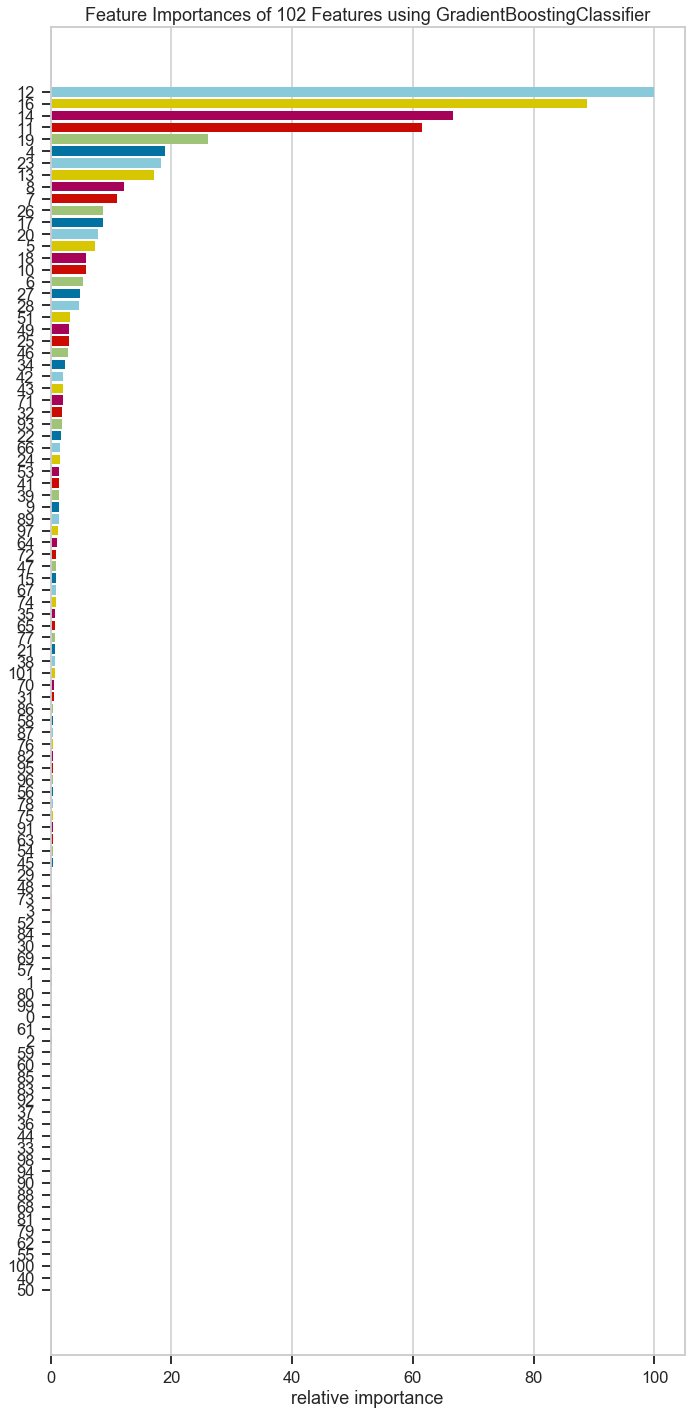

In [89]:
xgboost = GradientBoostingClassifier().fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
viz = FeatureImportances(xgboost)
viz.fit(X, y)
viz.show(outpath="images/output_images/feature_importance_i-e.png")
sns.set_context("talk")
plt.show()

##### Intuition (N) – Sensing (S)

In [90]:
X = result_svd_vec_dimensions.drop(["type","i-e", "n-s", "t-f", "j-p"], axis=1).values
y = result_svd_vec_dimensions["n-s"].values

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 102) (6940,) (1735, 102) (1735,)


In [66]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [67]:
models = {'gnb': GaussianNB(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [68]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_n-s.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.840778,0.847715,0.843228,0.843977,0.920112
0,randomforest,0.886599,0.879122,0.886023,0.859567,0.888221
0,xgboost,0.900288,0.888329,0.900288,0.886778,0.918648
0,MLPC,0.878386,0.871289,0.881556,0.857432,0.875813


###### Feature importance

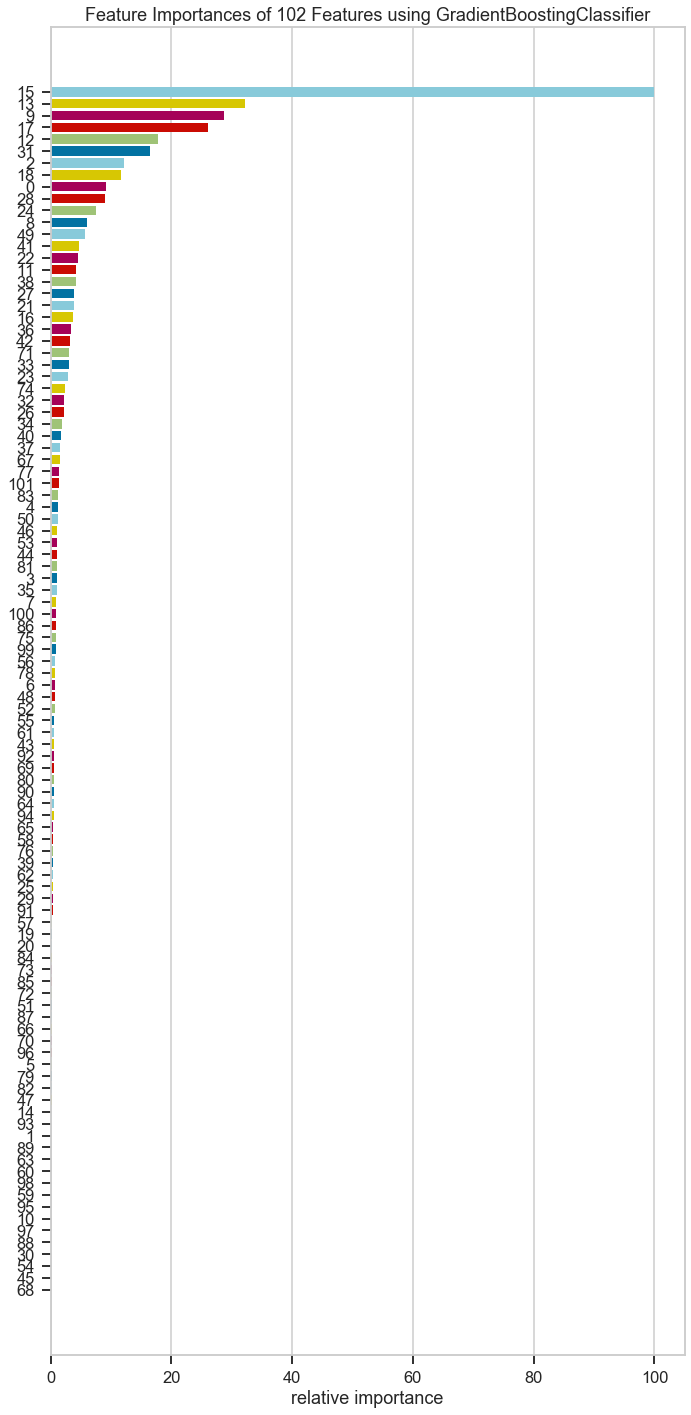

In [92]:
xgboost = GradientBoostingClassifier().fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
viz = FeatureImportances(xgboost)
viz.fit(X, y)
viz.show(outpath="images/output_images/feature_importance_n-s.png")
sns.set_context("talk")
plt.show()

##### Thinking (T) – Feeling (F)

In [93]:
X = result_svd_vec_dimensions.drop(["type","i-e", "n-s", "t-f", "j-p"], axis=1).values
y = result_svd_vec_dimensions["t-f"].values

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 102) (6940,) (1735, 102) (1735,)


In [73]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [74]:
models = {'gnb': GaussianNB(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [75]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_t-f.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.711816,0.723637,0.712248,0.711940,0.671351
0,randomforest,0.829539,0.831603,0.829251,0.826015,0.837432
0,xgboost,0.844957,0.844915,0.848271,0.843207,0.833333
0,MLPC,0.849135,0.852541,0.841931,0.845091,0.868195


###### Feature importance

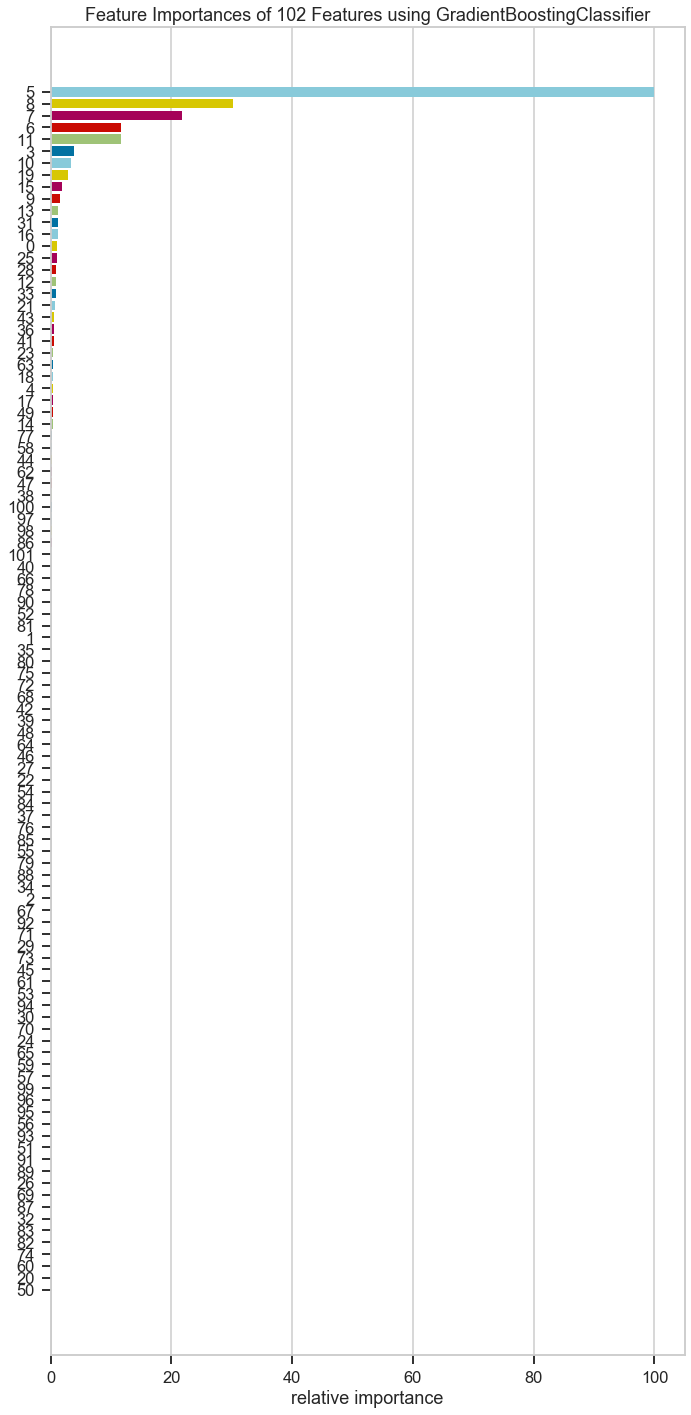

In [95]:
xgboost = GradientBoostingClassifier().fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
viz = FeatureImportances(xgboost)
viz.fit(X, y)
viz.show(outpath="images/output_images/feature_importance_t-f.png")
sns.set_context("talk")
plt.show()

##### Judging (J) – Perceiving (P)

In [96]:
X = result_svd_vec_dimensions.drop(["type","i-e", "n-s", "t-f", "j-p"], axis=1).values
y = result_svd_vec_dimensions["j-p"].values

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940, 102) (6940,) (1735, 102) (1735,)


In [79]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision_weighted'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall_weighted'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1_weighted'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'specificity'  : [specificity]
                            })   
    return df_model

In [80]:
models = {'gnb': GaussianNB(),
          'randomforest': RandomForestClassifier(),
          'xgboost': GradientBoostingClassifier(),
          'MLPC': MLPClassifier()
         }

In [81]:
# Evaluation of models
models_df = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df.to_csv("data/output_csv/models_j-p.csv")
models_df

,model,accuracy,precision,recall,f1score,specificity
0,gnb,0.716571,0.718007,0.715562,0.706528,0.681250
0,randomforest,0.773055,0.784808,0.779107,0.770559,0.800000
0,xgboost,0.787320,0.789693,0.790058,0.788014,0.790441
0,MLPC,0.736023,0.778140,0.734582,0.788530,0.831633


###### Feature importance

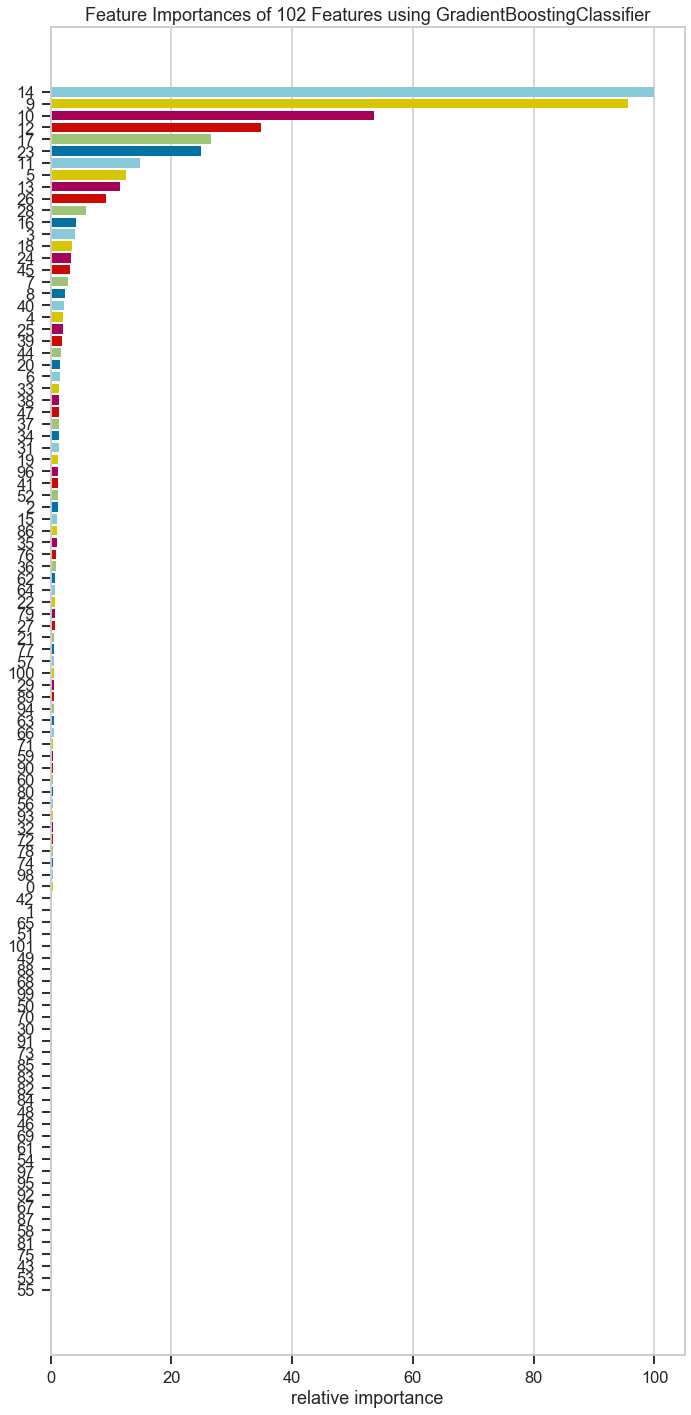

In [98]:
xgboost = GradientBoostingClassifier().fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
viz = FeatureImportances(xgboost)
viz.fit(X, y)
viz.show(outpath="images/output_images/feature_importance_j-p.png")
sns.set_context("talk")
plt.show()

**Comments**

In [99]:
dimensions = 0.835934 * 0.886778 * 0.843207 * 0.788014
types = 0.622888

print("F1 Scores:")
print("Types =", types,"vs","Dimensions =", dimensions)

F1 Scores:
Types = 0.622888 vs Dimensions = 0.4925553452527933


So, in the end, the model trained using types predicts better that applying the 4 models for the different dimensions consecutively, unless we are particularly interested in 1 of the personality dimensions so that using the model for that particular dimension would be recommended. 